Imagine having a dataset that you need to use for training a prediction model, but some of the features are missing. The good news is you don't need to throw some data away, just have to impute them. Below are steps you can take in order to create an imputation pipeline.

In [1]:
from random import randint

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import mlflow

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Generate data

Since this is an example and I don't want to get sued by using my company's data, synthetic data it is :)

This simulates a dataset from different pseudo-regions, with different characteristics. Real data will be much more varied, but I make it more obvious so it's easy to see the differences.

In [2]:
def generate_array_with_random_nan(lower_bound, upper_bound, size):
    a = np.random.randint(lower_bound, upper_bound+1, size=size).astype(float)
    mask = np.random.choice([1, 0], a.shape, p=[.1, .9]).astype(bool)
    a[mask] = np.nan
    
    return a

size = 6000

df_cbd = pd.DataFrame()
df_cbd['bed'] = generate_array_with_random_nan(1, 2, size)
df_cbd['bath'] = generate_array_with_random_nan(1, 2, size)
df_cbd['area_usable'] = np.random.randint(20, 40, size=size)
df_cbd['region'] = 'cbd'

df_suburb = pd.DataFrame()
df_suburb['bed'] = generate_array_with_random_nan(1, 4, size)
df_suburb['bath'] = generate_array_with_random_nan(1, 4, size)
df_suburb['area_usable'] = np.random.randint(30, 200, size=size)
df_suburb['region'] = 'suburb'

df = pd.concat([df_cbd, df_suburb])
df

,bed,bath,area_usable,region
0,2.0,2.0,34,cbd
1,1.0,NaN,39,cbd
2,NaN,1.0,28,cbd
3,2.0,1.0,26,cbd
4,2.0,2.0,36,cbd
...,...,...,...,...
5995,2.0,3.0,190,suburb
5996,2.0,3.0,181,suburb
5997,1.0,1.0,155,suburb
5998,3.0,4.0,40,suburb


# Report missin values

I also randomly remove some values to mimic real-world data (read: they are never ready to use), here we will visualize the missing rate of each column.

col: bed, missing: 10.266666666666667%
col: bath, missing: 9.616666666666667%
col: area_usable, missing: 0.0%
col: region, missing: 0.0%


<module 'seaborn' from '/Users/kahnwong/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/__init__.py'>

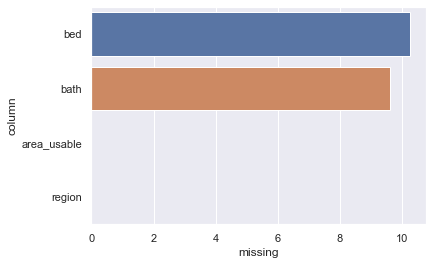

In [3]:
def report_missing(df):
    cnts = []
    cnt_total = len(df)
    for col in df.columns:
        cnt_missing = sum(pd.isnull(df[col]) | pd.isna(df[col]))
        print("col: {}, missing: {}%".format(col, 100.0 * cnt_missing / cnt_total))

        cnts.append({
            'column': col,
            'missing': 100.0 * cnt_missing / cnt_total
        })

    cnts_df = pd.DataFrame(cnts)
    sns.barplot(x=cnts_df.missing, 
                y=cnts_df.column, 
    #             palette=['r','b'],
    #             data=cnts_df
               )
    
    return sns

report_missing(df)

# Data exploration

Knowing the missing rate isn't everything, thus it is also a good idea to explore data in other areas too.

In [4]:
# missing bed per region
df[df.bed.isna()]["region"].value_counts(dropna=False)

cbd       634
suburb    598
Name: region, dtype: int64

In [5]:
# missing bath per region
df[df.bath.isna()]["region"].value_counts(dropna=False)

suburb    588
cbd       566
Name: region, dtype: int64

In [6]:
# explore region
df.region.value_counts()

suburb    6000
cbd       6000
Name: region, dtype: int64

In [7]:
# explore bed
df.bed.value_counts()

2.0    4050
1.0    4009
4.0    1393
3.0    1316
Name: bed, dtype: int64

In [8]:
# explore bath
df.bath.value_counts()

1.0    4142
2.0    4022
3.0    1393
4.0    1289
Name: bath, dtype: int64

# Remove outliers (wouldn't want your model to have a sub-par performance from skewed data :-P)

In [9]:
# remove outliers here

# Create synthetic columns

In this step, we create percentile, mean and rank columns to add more data points, so the model can perform better :D

First, we find aggregate percentiles for each groupby set, then add mean and rank columns.

In [10]:
synth_columns = {
    'bed': {
        "region_bath": ['region', 'bath']
    },
    'bath': {
        "region_bed": ['region', 'bed']
    }
}

for column, groupby_levels in synth_columns.items():
    for groupby_level_name, groupby_columns in groupby_levels.items():
        # percentile aggregates
        for pctl in [20,50,80,90]:
            col_name = 'p{}|{}|{}'.format(pctl, groupby_level_name, column)
            print("calculating -- {}".format(col_name))
            df[col_name] = df[groupby_columns+[column]].fillna(0).groupby(groupby_columns)[column].transform(lambda x: x.quantile(pctl/100.0))

        # mean impute
        mean_impute = 'mean|{}|{}'.format(groupby_level_name,column)
        print("calculating -- {}".format(mean_impute))
        df[mean_impute] = df.groupby(groupby_columns)[column].transform('mean')
        
        # bed/bath rank
        rank_impute = column_name = 'rank|{}|{}'.format(groupby_level_name,column)
        print("calculating -- {}".format(rank_impute))
        df[rank_impute] = df.groupby(groupby_columns)[column].rank(method='dense', na_option='bottom')
          
df

calculating -- p20|region_bath|bed
calculating -- p50|region_bath|bed
calculating -- p80|region_bath|bed
calculating -- p90|region_bath|bed
calculating -- mean|region_bath|bed
calculating -- rank|region_bath|bed
calculating -- p20|region_bed|bath
calculating -- p50|region_bed|bath
calculating -- p80|region_bed|bath
calculating -- p90|region_bed|bath
calculating -- mean|region_bed|bath
calculating -- rank|region_bed|bath


,bed,bath,area_usable,region,p20|region_bath|bed,p50|region_bath|bed,p80|region_bath|bed,p90|region_bath|bed,mean|region_bath|bed,rank|region_bath|bed,p20|region_bed|bath,p50|region_bed|bath,p80|region_bed|bath,p90|region_bed|bath,mean|region_bed|bath,rank|region_bed|bath
0,2.0,2.0,34,cbd,1.0,1.0,2.0,2.0,1.492699,2.0,1.0,1.0,2.0,2.0,1.488825,2.0
1,1.0,NaN,39,cbd,1.0,1.0,2.0,2.0,NaN,1.0,1.0,1.0,2.0,2.0,1.497138,3.0
2,NaN,1.0,28,cbd,1.0,1.0,2.0,2.0,1.501014,3.0,1.0,1.0,2.0,2.0,NaN,1.0
3,2.0,1.0,26,cbd,1.0,1.0,2.0,2.0,1.501014,2.0,1.0,1.0,2.0,2.0,1.488825,1.0
4,2.0,2.0,36,cbd,1.0,1.0,2.0,2.0,1.492699,2.0,1.0,1.0,2.0,2.0,1.488825,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2.0,3.0,190,suburb,1.0,2.0,4.0,4.0,2.514469,2.0,1.0,2.0,4.0,4.0,2.473556,3.0
5996,2.0,3.0,181,suburb,1.0,2.0,4.0,4.0,2.514469,2.0,1.0,2.0,4.0,4.0,2.473556,3.0
5997,1.0,1.0,155,suburb,1.0,2.0,4.0,4.0,2.505221,1.0,1.0,2.0,4.0,4.0,2.477712,1.0
5998,3.0,4.0,40,suburb,1.0,2.0,4.0,4.0,2.504770,3.0,1.0,2.0,4.0,4.0,2.471322,4.0


# Coalesce values

In this step we fill in values obtained from the previous step -- impute time!!

In [11]:
def coalesce(df, columns):
    '''
    Implement coalesce of function in colunms.
    
    Inputs:
    df: reference dataframe
    columns: columns to perform coalesce
    
    Returns:
    df_tmp: pd.Series that is coalesced
    
    Example:
    df_tmp = pd.DataFrame({'a': [1,2,None,None,None,None], 
                            'b': [None,6,None,8,9,None], 
                            'c': [None,10,None,12,None,13]})
    df_tmp['new'] = coalesce(df_tmp, ['a','b','c'])
    print(df_tmp)
    '''
    df_tmp = df[columns[0]]
    for c in columns[1:]:
        df_tmp = df_tmp.fillna(df[c])
    
    return df_tmp


coalesce_columns = [
    'bed',
    'p50|region_bath|bed',
    # p50|GROUPBY_LESSER_WEIGHT|bed, ...
]

df["bed_imputed"] = coalesce(df, coalesce_columns)

coalesce_columns = [
    'bath',
    'p50|region_bed|bath',
     # p50|GROUPBY_LESSER_WEIGHT|bath, ...
]

df["bath_imputed"] = coalesce(df, coalesce_columns)

df

,bed,bath,area_usable,region,p20|region_bath|bed,p50|region_bath|bed,p80|region_bath|bed,p90|region_bath|bed,mean|region_bath|bed,rank|region_bath|bed,p20|region_bed|bath,p50|region_bed|bath,p80|region_bed|bath,p90|region_bed|bath,mean|region_bed|bath,rank|region_bed|bath,bed_imputed,bath_imputed
0,2.0,2.0,34,cbd,1.0,1.0,2.0,2.0,1.492699,2.0,1.0,1.0,2.0,2.0,1.488825,2.0,2.0,2.0
1,1.0,NaN,39,cbd,1.0,1.0,2.0,2.0,NaN,1.0,1.0,1.0,2.0,2.0,1.497138,3.0,1.0,1.0
2,NaN,1.0,28,cbd,1.0,1.0,2.0,2.0,1.501014,3.0,1.0,1.0,2.0,2.0,NaN,1.0,1.0,1.0
3,2.0,1.0,26,cbd,1.0,1.0,2.0,2.0,1.501014,2.0,1.0,1.0,2.0,2.0,1.488825,1.0,2.0,1.0
4,2.0,2.0,36,cbd,1.0,1.0,2.0,2.0,1.492699,2.0,1.0,1.0,2.0,2.0,1.488825,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2.0,3.0,190,suburb,1.0,2.0,4.0,4.0,2.514469,2.0,1.0,2.0,4.0,4.0,2.473556,3.0,2.0,3.0
5996,2.0,3.0,181,suburb,1.0,2.0,4.0,4.0,2.514469,2.0,1.0,2.0,4.0,4.0,2.473556,3.0,2.0,3.0
5997,1.0,1.0,155,suburb,1.0,2.0,4.0,4.0,2.505221,1.0,1.0,2.0,4.0,4.0,2.477712,1.0,1.0,1.0
5998,3.0,4.0,40,suburb,1.0,2.0,4.0,4.0,2.504770,3.0,1.0,2.0,4.0,4.0,2.471322,4.0,3.0,4.0


# Report missing values (again)

After we impute the values, let's see how much we are doing better!

col: bed, missing: 10.266666666666667%
col: bath, missing: 9.616666666666667%
col: area_usable, missing: 0.0%
col: region, missing: 0.0%
col: p20|region_bath|bed, missing: 0.0%
col: p50|region_bath|bed, missing: 0.0%
col: p80|region_bath|bed, missing: 0.0%
col: p90|region_bath|bed, missing: 0.0%
col: mean|region_bath|bed, missing: 9.616666666666667%
col: rank|region_bath|bed, missing: 0.0%
col: p20|region_bed|bath, missing: 0.0%
col: p50|region_bed|bath, missing: 0.0%
col: p80|region_bed|bath, missing: 0.0%
col: p90|region_bed|bath, missing: 0.0%
col: mean|region_bed|bath, missing: 10.266666666666667%
col: rank|region_bed|bath, missing: 0.0%
col: bed_imputed, missing: 0.0%
col: bath_imputed, missing: 0.0%


<module 'seaborn' from '/Users/kahnwong/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/__init__.py'>

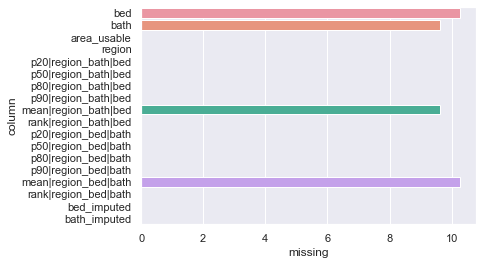

In [12]:
report_missing(df)

Notice that the imputed columns there are no missing values. Yay!

# Assign partition
In this step, we partition the data into three sets: train, dev and test. Normally we only split into train and test set, but the additional "dev" set is there so we can make sure it's not too overfit or underfit.

In [13]:
# assign partition
def assign_partition(x):
    if x in [0,1,2,3,4,5]:
        return 0
    elif x in [6,7]:
        return 1
    else:
        return 2

# assign random id
df['listing_id'] = [randint(1000000, 9999999) for i in range(len(df))]

# hashing
df["hash_id"] = df["listing_id"].apply(lambda x: x % 10)

# assign partition
df["partition_id"] = df["hash_id"].apply(lambda x: assign_partition(x))

In [14]:
# define columns group
y_column = 'area_usable'

categ_columns = ['region']

numer_columns = [
    'bed_imputed',
    'bath_imputed',
    
    'p20|region_bath|bed',
    'p50|region_bath|bed',
    'p80|region_bath|bed',
    'p90|region_bath|bed',
    'mean|region_bath|bed',
    'rank|region_bath|bed',
    
    'p20|region_bed|bath',
    'p50|region_bed|bath',
    'p80|region_bed|bath',
    'p90|region_bed|bath',
    'mean|region_bed|bath',
    'rank|region_bed|bath',
]

id_columns = [
    'listing_id',
    'hash_id',
    'partition_id'
]

In [15]:
# remove missing y
df = df.dropna(subset=[y_column])

# split into train-dev-test
df_train = df[df["partition_id"] == 0]
df_dev = df[df["partition_id"] == 1]
df_test = df[df["partition_id"] == 2]

In [16]:
# split each set into x and y
y_train = df_train[y_column].values
df_train = df_train[numer_columns+categ_columns]

y_dev = df_dev[y_column].values
df_dev = df_dev[numer_columns+categ_columns]

y_test = df_test[y_column].values
df_test = df_test[numer_columns+categ_columns]

In [17]:
df_train

,bed_imputed,bath_imputed,p20|region_bath|bed,p50|region_bath|bed,p80|region_bath|bed,p90|region_bath|bed,mean|region_bath|bed,rank|region_bath|bed,p20|region_bed|bath,p50|region_bed|bath,p80|region_bed|bath,p90|region_bed|bath,mean|region_bed|bath,rank|region_bed|bath,region
0,2.0,2.0,1.0,1.0,2.0,2.0,1.492699,2.0,1.0,1.0,2.0,2.0,1.488825,2.0,cbd
2,1.0,1.0,1.0,1.0,2.0,2.0,1.501014,3.0,1.0,1.0,2.0,2.0,NaN,1.0,cbd
4,2.0,2.0,1.0,1.0,2.0,2.0,1.492699,2.0,1.0,1.0,2.0,2.0,1.488825,2.0,cbd
6,2.0,1.0,1.0,1.0,2.0,2.0,1.501014,2.0,1.0,1.0,2.0,2.0,1.488825,1.0,cbd
10,2.0,2.0,1.0,1.0,2.0,2.0,1.492699,2.0,1.0,1.0,2.0,2.0,1.488825,2.0,cbd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988,2.0,4.0,1.0,2.0,4.0,4.0,2.504770,5.0,1.0,2.0,4.0,4.0,NaN,4.0,suburb
5991,3.0,2.0,1.0,2.0,4.0,4.0,2.535889,3.0,1.0,2.0,4.0,4.0,2.471322,2.0,suburb
5993,1.0,3.0,1.0,2.0,4.0,4.0,2.514469,1.0,1.0,2.0,4.0,4.0,2.477712,3.0,suburb
5996,2.0,3.0,1.0,2.0,4.0,4.0,2.514469,2.0,1.0,2.0,4.0,4.0,2.473556,3.0,suburb


# Create sklearn pipelines

In this step, we chain a few pipelines together to process the dataset for the final time. In this example, we use median followed by standard scalar for numeric columns, and mode followed by encoding labels for categorical columns.

In [18]:
# define pipelines
impute_median = SimpleImputer(strategy='median')
impute_mode = SimpleImputer(strategy='most_frequent')

num_pipeline = Pipeline([
        ('impute_median', impute_median),
        ('std_scaler', StandardScaler()),
    ])

categ_pipeline = Pipeline([
        ('impute_mode', impute_mode),
        ('categ_1hot', OneHotEncoder(handle_unknown='ignore')),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numer_columns),
        ("cat", categ_pipeline, categ_columns),
    ])

In [19]:
# fit and transform
X_train = full_pipeline.fit_transform(df_train)
X_dev = full_pipeline.transform(df_dev)
X_test = full_pipeline.transform(df_test)

In [20]:
X_train

array([[ 0.04673184,  0.06391404,  0.        , ..., -0.16000115,
         1.        ,  0.        ],
       [-0.97000929, -0.97263688,  0.        , ..., -1.01065389,
         1.        ,  0.        ],
       [ 0.04673184,  0.06391404,  0.        , ..., -0.16000115,
         1.        ,  0.        ],
       ...,
       [-0.97000929,  1.10046497,  0.        , ...,  0.69065159,
         0.        ,  1.        ],
       [ 0.04673184,  1.10046497,  0.        , ...,  0.69065159,
         0.        ,  1.        ],
       [ 1.06347297,  2.13701589,  0.        , ...,  1.54130432,
         0.        ,  1.        ]])

# Hyperparameter tuning

In this step, we try to use different models and parameters to see which performs the best. We utilize mlflow for logging and hyperopt to help with tuning. In this example, we run the trials for 20 iterations, each using a different combination of model and parameters.

In [21]:
# mlflow + hyperopt combo
def objective(params):
    regressor_type = params['type']
    del params['type']
    if regressor_type == 'gradient_boosting_regression':
        estimator = GradientBoostingRegressor(**params)
    elif regressor_type == 'random_forest_regression':
        estimator = RandomForestRegressor(**params)
    elif regressor_type == 'extra_trees_regression':
        estimator = ExtraTreesRegressor(**params)
    elif regressor_type == 'decision_tree_regression':
        estimator = DecisionTreeRegressor(**params)
    else:
        return 0    
    
    estimator.fit(X_train, y_train)
    
    # mae    
    y_dev_hat = estimator.predict(X_dev)
    mae = median_absolute_error(y_dev, y_dev_hat)
    
    # logging
    with mlflow.start_run():
        mlflow.log_param("regressor", estimator.__class__.__name__)
        # mlflow.log_param("params", params)
        mlflow.log_param('n_estimators', params.get('n_estimators'))
        mlflow.log_param('max_depth', params.get('max_depth'))
        
        mlflow.log_metric("median_absolute_error", mae)  
    
    return {'loss': mae, 'status': STATUS_OK}

space = hp.choice('regressor_type', [    
    {
        'type': 'gradient_boosting_regression',
        'n_estimators': hp.choice('n_estimators1', range(100,200,50)),
        'max_depth': hp.choice('max_depth1', range(10,13,1))
    },
    {
        'type': 'random_forest_regression',
        'n_estimators': hp.choice('n_estimators2', range(100,200,50)),
        'max_depth': hp.choice('max_depth2', range(3,25,1)),
        'n_jobs': -1
        
    },
    {
        'type': 'extra_trees_regression',
        'n_estimators': hp.choice('n_estimators3', range(100,200,50)),
        'max_depth': hp.choice('max_depth3', range(3,10,2))
    },
    {
        'type': 'decision_tree_regression',
        'max_depth': hp.choice('max_depth4', range(3,10,2))
    }
])

trials = Trials()
max_evals = 20

best = fmin(
fn=objective, 
space=space,
algo=tpe.suggest,
max_evals=max_evals,
trials=trials)

print("Found minimum after {} trials:".format(max_evals))
from pprint import pprint
pprint(best)

100%|██████████| 20/20 [00:09<00:00,  2.07trial/s, best loss: 8.812719990864075]
Found minimum after 20 trials:
{'max_depth2': 2, 'n_estimators2': 0, 'regressor_type': 1}


# Evaluate performance

Run "mlflow server" to see the loggin dashboard. There, we can see that "Decision Tree Regressor" has the best performance (the less MAE the better) when using max_depth = 0, to test the model's performance against another test set:

In [22]:
# use best params on TEST set
estimator = DecisionTreeRegressor(max_depth=3)
estimator.fit(X_train, y_train)
    
y_train_hat = estimator.predict(X_train)
train_mae = median_absolute_error(y_train, y_train_hat)

y_dev_hat = estimator.predict(X_dev)
dev_mae = median_absolute_error(y_dev, y_dev_hat)

y_test_hat = estimator.predict(X_test)
test_mae = median_absolute_error(y_test, y_test_hat)

mae =  {
    'name': estimator.__class__.__name__,
    'train_mae': train_mae,
    'dev_mae': dev_mae,
    'test_mae': test_mae
}

mae = pd.DataFrame([mae]).set_index('name')

mae

,train_mae,dev_mae,test_mae
name,,,
DecisionTreeRegressor,8.793598,8.793598,9.421525


You'll notice that we use "median absolute error" to measure performance. There are other metrics available, such as mean squared error, but in some cases it's more meaningful to use a metric that measure the performance in actual data's unit, in this case the error on dev and test set are 8 units away from its correct value. Since normally we use square meter for area, it means the prediction will be off by about 8 square meters in most cases.